In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_excel('adidas.xlsx')
df

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,600000.0,300000.00,0.50,In-store
1,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,500000.0,150000.00,0.30,In-store
2,Foot Locker,1185732,2020-01-03,Northeast,New York,New York,Women's Street Footwear,40.0,1000,400000.0,140000.00,0.35,In-store
3,Foot Locker,1185732,2020-01-04,Northeast,New York,New York,Women's Athletic Footwear,45.0,850,382500.0,133875.00,0.35,In-store
4,Foot Locker,1185732,2020-01-05,Northeast,New York,New York,Men's Apparel,60.0,900,540000.0,162000.00,0.30,In-store
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9643,Foot Locker,1185732,2021-01-24,Northeast,New Hampshire,Manchester,Men's Apparel,50.0,64,3200.0,896.00,0.28,Outlet
9644,Foot Locker,1185732,2021-01-24,Northeast,New Hampshire,Manchester,Women's Apparel,41.0,105,4305.0,1377.60,0.32,Outlet
9645,Foot Locker,1185732,2021-02-22,Northeast,New Hampshire,Manchester,Men's Street Footwear,41.0,184,7544.0,2791.28,0.37,Outlet
9646,Foot Locker,1185732,2021-02-22,Northeast,New Hampshire,Manchester,Men's Athletic Footwear,42.0,70,2940.0,1234.80,0.42,Outlet


In [3]:
df = df[['Invoice Date', 'Units Sold']]
df

,Invoice Date,Units Sold
0,2020-01-01,1200
1,2020-01-02,1000
2,2020-01-03,1000
3,2020-01-04,850
4,2020-01-05,900
...,...,...
9643,2021-01-24,64
9644,2021-01-24,105
9645,2021-02-22,184
9646,2021-02-22,70


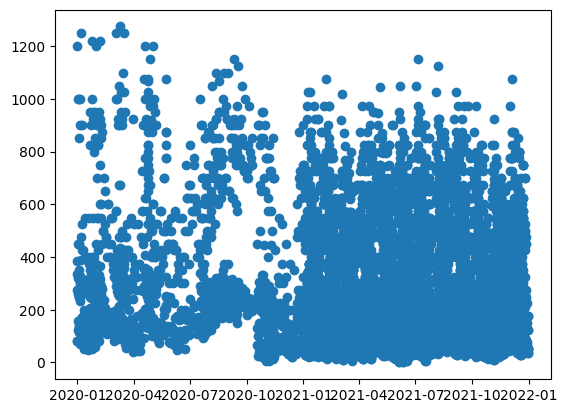

In [4]:
plt.scatter(df['Invoice Date'], df['Units Sold'])
plt.show()

In [5]:
df.dtypes

Invoice Date    datetime64[ns]
Units Sold               int64
dtype: object

In [6]:
df = df.sort_values(by='Invoice Date')

In [7]:
df['Year'] = df['Invoice Date'].dt.year
df['Month'] = df['Invoice Date'].dt.month
df['Day'] = df['Invoice Date'].dt.day
df = df.drop(columns=['Invoice Date'])
df

,Units Sold,Year,Month,Day
0,1200,2020,1,1
499,275,2020,1,1
8203,83,2020,1,1
3888,336,2020,1,1
7776,384,2020,1,1
...,...,...,...,...
498,175,2021,12,31
4386,47,2021,12,31
8202,56,2021,12,31
5088,36,2021,12,31


In [41]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

In [42]:
#Scaling the data
scaler = QuantileTransformer()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.shape

(9648, 4)

In [10]:
df_scaled


,Units Sold,Year,Month,Day
0,4.401913,-2.531825,-1.579950,-1.864042
1,0.084344,-2.531825,-1.579950,-1.864042
2,-0.811843,-2.531825,-1.579950,-1.864042
3,0.369070,-2.531825,-1.579950,-1.864042
4,0.593117,-2.531825,-1.579950,-1.864042
...,...,...,...,...
9643,-0.382420,0.394972,1.604192,2.218902
9644,-0.979878,0.394972,1.604192,2.218902
9645,-0.937870,0.394972,1.604192,2.218902
9646,-1.031222,0.394972,1.604192,2.218902


In [43]:
sequence_length = 60
X, y  = [], []
for i in range(len(df_scaled)- sequence_length):
    j = i+sequence_length
    X.append(df_scaled.iloc[i : j].values)
    y.append(df_scaled["Units Sold"].iloc[j])

X = np.array(X)
y = np.array(y)
X.shape


(9588, 60, 4)

In [12]:
y.shape

(9618,)

In [44]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [65]:
#Model Building
lstm_model = keras.Sequential([
    layers.Input(shape=(sequence_length, 4)),
    layers.BatchNormalization(),

    layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),


    layers.LSTM(32),
    layers.BatchNormalization(),
    layers.Dropout(0.2),


    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber' , metrics=['mae', 'mse'])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [66]:
from tensorflow.keras import  callbacks

In [69]:
def get_callbacks(patience_lr=5, patience_stop=10):
    callbacks_list = [
        # Learning rate reduction
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=patience_lr,
            min_lr=1e-6,
            verbose=1
        ),
        # Early stopping
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience_stop,
            restore_best_weights=True,
            verbose=1
        ),
    ]
    return callbacks_list

In [70]:
batch_size = min(64, 2**int(np.log2(len(X_train)/100)))

history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, validation_split=0.2, callbacks=get_callbacks())

Epoch 1/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - loss: 1.5028 - mae: 0.5194 - mse: 0.5019 - val_loss: 0.3140 - val_mae: 0.2586 - val_mse: 0.0966 - learning_rate: 0.0010
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - loss: 0.2391 - mae: 0.2726 - mse: 0.1060 - val_loss: 0.0969 - val_mae: 0.2472 - val_mse: 0.0836 - learning_rate: 0.0010
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0874 - mae: 0.2586 - mse: 0.0922 - val_loss: 0.0583 - val_mae: 0.2431 - val_mse: 0.0816 - learning_rate: 0.0010
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 0.0641 - mae: 0.2556 - mse: 0.0893 - val_loss: 0.0497 - val_mae: 0.2422 - val_mse: 0.0802 - learning_rate: 0.0010
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - loss: 0.0530 - mae: 0.2506 - mse: 0.0860 - val_loss: 0.0662 - val_mae: 0.2903 - val_mse: 0.1228 - learning_rate: 0.0010
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - loss: 0.0480 - mae: 0.2515 - mse: 0.0862 - val_loss: 0.043

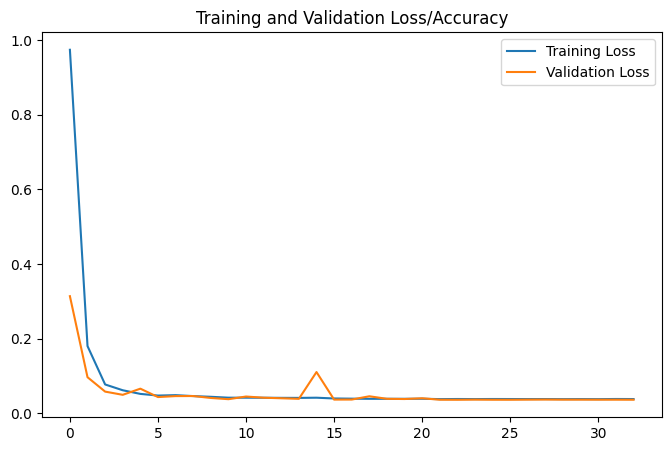

In [71]:
train_loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.figure(figsize=(8, 5))  # Adjust figure size as needed# Label accordingly
plt.title('Training and Validation Loss/Accuracy')
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


ValueError: x and y can be no greater than 2D, but have shapes (100,) and (100, 60, 4)

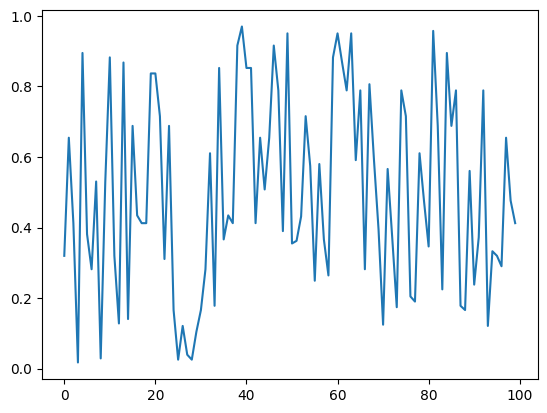

In [73]:
predictions = lstm_model.predict(X_test)
plt.plot(y_test[:100], label='Actual Sales')
plt.plot(predictions[:100], label='Predicted Sales')
plt.legend()
plt.show()